In [1]:
import numpy as np
from matplotlib    import pyplot as plt
from numpy.random  import default_rng
from tqdm          import tqdm
from time          import perf_counter 
from scipy.stats   import pearsonr, poisson, wishart, multivariate_normal, norm, vonmises, multivariate_t, laplace
from scipy.special import gamma, factorial, gammaln
from scipy.special import i0 as I0
from dw_tools      import bivariate_tools

new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none',
    "font.size" : 12,
}
plt.rcParams.update(new_rc_params)
fig_dir = "results_figs/"

In [2]:
# %autosave 300
# %load_ext autoreload
# %autoreload 2

# A model for bivariate priors

# Introduction
In this notebook, we examine the joint distribution of pairs of structure factor amplitudes conditional on a third reference set of amplitudes. We will assume that the two datasets have joint correlation parameter $r_x$ as specified below, and both of their correlations with the reference dataset are described by a correlation parameter $r$. These parameters play the same role as $r$ or $r_{DW}$ in the preceding notebooks.

Under the multivariate Wilson model, we examine:
1. **Joint probability distributions of $(E_1,E_2,E_3)$**. We compute the joint probability distribution of $(E_1, E_2)$, both unconditional and conditional on $E_3$.
2. **The Bivariate Rice Distribution**. We present a formalism for bivariate Rice distributions introduced by Abu-Dayya & Beaulieu (1994). To do so, we first review the derivation of the Rice distribution to establish notation. We find that the joint distribution of $(E_1, E_2)$ conditional on $E_3$ can be parametrized in the formalism of Abu-Dayya & Beaulieu and yields results consistent with numerical simulations up to numerical and sampling errors.
3. **Normal approximations to the distribution of $\Delta|E|$.** We fit the distribution of $\Delta|E| = |E_2| - |E_1|$ to a normal PDF and examine the variance of the centric and acentric $\Delta|E|$. 

# Joint probability distributions of $(E_1,E_2,E_3)$

Consider three normalized structure factors for related structures, $\left(E_1, E_2, E_3=E_{ref}\right)$ with joint probability density. In the multivariate Wilson model,

$$
P\left(E_1,E_2,E_3\right) = P\left(E_{1x},E_{2x},E_{3x},E_{1y},E_{2y},E_{3y}\right)=N\left(0,C\right)
$$

(note the rearrangement of rows), with 

$$
C = \frac{1}{2}
\begin{bmatrix}
1   & r_x & r & 0   & 0   & 0  \\
r_x & 1   & r & 0   & 0   & 0  \\
r   & r   & 1 & 0   & 0   & 0  \\
0   & 0   & 0 & 1   & r_x & r  \\
0   & 0   & 0 & r_x & 1   & r  \\
0   & 0   & 0 & r   & r   & 1  
\end{bmatrix}
$$

## Conditional joint probability distribution of $(E_1, E_2)$ given $E_3$

### General considerations
Following https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions, 

$$
P\left(E_1,E_2 | E_3\right) = P\left(E_{1x},E_{2x},E_{1y},E_{2x}|E_{3x}, E_{3y}\right)=\mathcal{N}\left(r E_3,C_{1,2|3}\right)
$$

(note the rearrangement of rows), with conditional covariance matrix

$$
C_{1,2|3} = \frac{1}{2}
\begin{bmatrix}
1   -r^2 & r_x -r^2 & 0       & 0        \\
r_x -r^2 & 1   -r^2 & 0       & 0        \\
0        & 0        & 1  -r^2 & r_x -r^2 \\
0        & 0        & r_x-r^2 & 1 -r^2  
\end{bmatrix}
$$

Note that $r$ and $r_x$ cannot adopt arbitrary combinations of values. Specifically, the conditional covariance matrix is only positive definite if $1+r_x \geq 2r^2$. $E_1$ and $E_2$ are conditionally independent (and uncorrelated) when $r_x = r^2$. In that case, $1+r_x = 1+r^2 \geq 2r^2 $.

For use of the bivariate Rice distribution below, we will also want to know the Pearson correlation coefficient for complex structure factors,

$$
\begin{align}
\rho\left(E_1,E_2|E_3\right) & = \frac{\mathbb{E}(E_1 E_2^*)-\mathbb{E}(E_1)\mathbb{E}(E_2^*)}
                                    {\sqrt{Var(E_1)Var(E_2)}} \\
                             & = \frac{\mathbb{E}\left((E_1-\mu_{1|3}+\mu_{1|3}) (E_2-\mu_{2|3}+\mu_{2|3})^*\right)
                                       -\mathbb{E}(E_1)\mathbb{E}(E_2^*)}
                                    {\sqrt{Var(E_1)Var(E_2)}} \\
                             & = \frac{Cov(E_1, E_2^*)+\mu\mu^*-\mu\mu^*}
                                    {\sqrt{Var(E_1)Var(E_2)}} \\
                             & = \frac{Cov(E_{1x}, E_{2x}) + Cov(E_{1y}, E_{2y})+0}{\sqrt{Var(E_1)Var(E_2)}} \\
                             & = \frac{r_x-r^2}{1-r^2}
\end{align}
$$

with the variances analogously defined as $Var(E_1)=\mathbb{E}(E_1 E_1^*)-\mathbb{E}(E_1)\mathbb{E}(E_1^*)$, etc.

In [3]:
def rho_xy(r,rx):
    return (rx-r**2)/(1-r**2)

Numerical check:

In [4]:
rng = default_rng()
r   = 0.8
rx  = 0.9
mean= np.asarray([1.5,1.5,0,0])
n_samples = int(1e7)
cov = 0.5*\
    np.asarray([[ 1-r**2, rx-r**2,0,      0      ],\
                [rx-r**2,  1-r**2,0,      0      ],\
                [0,        0,     1-r**2, rx-r**2],\
                [0,        0,    rx-r**2,  1-r**2]])
vals = rng.multivariate_normal(mean,cov,n_samples)

cov_1_2 = np.cov(vals[:,0],vals[:,1]) + np.cov(vals[:,2],vals[:,3])
var_1_1 = np.var(vals[:,0]) + np.var(vals[:,2])
var_2_2 = np.var(vals[:,1]) + np.var(vals[:,3])
print(f"expected rho(x, y):  {rho_xy(r,rx):.4f}")
print(f"observed rho(x, y):  {cov_1_2[0,1]/np.sqrt(var_1_1*var_2_2):.4f}") #I should improve the variable names
print(f"Expected errors   : ~{1/np.sqrt(n_samples):.4f}")

expected rho(x, y):  0.7222
observed rho(x, y):  0.7222
Expected errors   : ~0.0003


# The Bivariate Rice Distribution 
### (Abu-Dayya & Beaulieu; Beaulieu & Hemachandra)

**First, we'll consider briefly the derivation of the univariate Rice distribution**.

Consider, again, a pair of variables $\left(E_1, E_{3}\right)$, with $E_1=(E_{1x}, E_{1y})$, and $E_{3}=(E_{3x}, E_{3y})$ jointly normal, $\sim N\left((0,0,0,0),C\right)$, with 

$$
C = 
\frac{\Sigma}{2}
\begin{bmatrix}
1 & 0 & r & 0 \\
0 & 1 & 0 & r \\
r & 0 & 1 & 0 \\
0 & r & 0 & 1  
\end{bmatrix}
$$

The notation is such that $\left<|E_1|^2\right>=\left<E_{1x}^2+E_{1y}^2\right>=\Sigma$. For already normalized structure factors, rather than $F$'s, $\Sigma=1$.

Now, when we have a known value for $E_3=(E_{3,x}, E_{3,y})$, the conditional distribution of (complex) $E$ becomes a bivariate normal with mean $\mu = r E_{3}$, with $r$ playing the role of $r_{DW}$ in the double-Wilson model, and covariance matrix 

$$C_{1|3} = \frac{\Sigma}{2}
\begin{bmatrix}
1-r^2 & 0 \\
0 & 1-r^2
\end{bmatrix}
$$

It is helpful to write this in polar coordinates using $E_1 = R_1 \left(\cos(\phi_1),\sin(\phi_1)\right)$ and $\mu = r E_3 = R_3 \left(\cos(\phi_3),\sin(\phi_3)\right)$, such that

$$
\begin{align}
P\left(R_1,\phi_1 | R_3, \phi_3\right) & =  R_1 \frac{1}{2 \pi \sqrt{\det(C_{1|3})}} * 
                                       \exp\left(
                                           -\frac{1}{2}
                                           \left(R_1\cos(\phi_1)-R_3\cos(\phi_3), 
                                                 R_1\sin(\phi_1)-R_3\sin(\phi_3)
                                           \right)
                                           C_{1|3}^{-1}
                                           \left(R_1\cos(\phi_1)-R_3\cos(\phi_3), 
                                                 R_1\sin(\phi_1)-R_3\sin(\phi_3)
                                           \right)^T
                                       \right)\\
                                       & = 
                                       R_1 \frac{1}{2 \pi \sqrt{\det(C_{1|3})}} * 
                                       \exp\left(
                                           -\frac{R_1^2 + R_3^2}{\Sigma(1-r^2)}
                                           +\frac{R_1 R_3 (\cos(\phi_1)\cos(\phi_3)-
                                                                      \sin(\phi_1)\sin(\phi_3))}
                                                            {\Sigma(1-r^2)}          
                                           \right) \\
                                       & = 
                                        \frac{R_1}{\pi \Sigma (1-r^2)}  
                                       \exp\left(
                                           -\frac{R_1^2 + R_3^2}{\Sigma(1-r^2)}
                                           +\frac{R_1 R_3 \cos(\phi_1-\phi_3)}{\Sigma(1-r^2)}          
                                           \right)
\end{align}                                           
$$

where we use that $C_{1|3}^{-1} = \frac{2}{\Sigma} \frac{1}{1-r^2}$ and $\det(C_{1|3}) = \left(\frac{\Sigma}{2}(1-r^2)\right)^2$.

We can marginalize over $\Delta\phi = \phi_1-\phi_3$,

$$
\begin{align}
P\left(R_1 | R_3\right) & = \int_{0}^{2\pi} d\Delta\phi
                                 \frac{R_1}{\pi \Sigma (1-r^2)} * 
                                 \exp\left(
                                     -\frac{R_1^2 + R_3^2}{\Sigma(1-r^2)}
                                     +\frac{R_1 R_3 \cos(\Delta\phi)}{\Sigma(1-r^2)}          
                                 \right) \\
                        & = \frac{2 R_1}{\Sigma (1-r^2)} 
                                 \exp\left(
                                     -\frac{R_1^2 + R_3^2}{\Sigma(1-r^2)}
                                 \right)
                            I_0\left(
                                \frac{2 R_1 R_3}{\Sigma(1-r^2)}          
                            \right)
\end{align}                                           
$$

which is the Rice distribution. For comparison to Bricogne (1999), his $R_B$ is our $R_1$, his $r_B$ is our $R_3=r|E_3|$, and his $\Sigma_B$ is $\frac{\Sigma}{2}(1-r^2)$, our per-term conditional variance (we added the $B$ subscripts to indicate "Bricogne").

### Abu-Dayya & Beaulieu, "Switched Diversity in Microcellular Ricean Channels"

The Rice distribution is of interest in the wireless communication literature. The equation above maps to the "Ricean PDF" in eq. 1 of Abu-Dayya and Beaulieu (1994), with $K = R_3^2/\Sigma(1-r^2)$ in our terms, or $R^2/\Sigma$ in Bricogne (1999), eq. 1.6's, and $\frac{1+K}{\beta}=2/\Sigma(1-r^2)$ in our terms, or $1/\Sigma_B$ in Bricogne's. Recall that  $R_3=r|E_3|$. In this formalism,

$$P\left(R_1\right|E_3) = \frac{R_1(1+K)}{\beta}\exp\left(-K-\frac{(1+K)R_1^2}{2\beta}\right)\times 
                                            I_0\left(2R_1\sqrt{\frac{K(1+K)}{2\beta}}\right)
$$                                            

**This formalism is worth studying, because Abu-Dayya and Beaulieu derive a bivariate Rice distribution, with**

$$
\begin{align}
P\left(R_1,R_2 | R_3\right) = & \frac{(1+K)^2 R_1 R_2}{2\pi \beta^2(1-v^2)}
                        \exp\left(
                            \frac{-2K}{1+v} - \frac{(1+K)(R_1^2+R_2^2)}{2(1-v^2)\beta}
                        \right) \\ 
                        & \times
                        \int_{0}^{2\pi} \exp\left(
                            \frac{v(1+K)R_1 R_2 \cos \theta}{(1-v^2)\beta}
                        \right) \\
                        & \times I_0\left(
                            \sqrt{\frac{2K(1+K)(R_1^2 + R_2^2+2R_1R_2\cos\theta}{\beta(1+v)^2}}
                        \right) d\theta
\end{align}
$$

with 

$$
v = \frac{\left<\left(E_1^* - \left<E_1^*\right>\right)\left(E_2 - \left<E_2\right>\right)\right>}
         {\sqrt{
             \left<\left|E_1 - \left<E_1\right>\right|^2\right>
             \left<\left|E_2 - \left<E_2\right>\right|^2\right>       
              }}
$$

For the case of the pdf of $E_1$ and $E_2$ conditional on $E_3$, we derive and validate an expression for $v$ above, namely

$$
v=\frac{r_x-r^2}{1-r^2}
$$

Note that the expression for $v$ is equivalent to the expression for $\rho_{k,j}=\lambda_k \lambda_j$ in Beaulieu & Hemachandra (2011).

## Acentric structure factors

We begin by sampling directly from the conditional distribution of $E_1$ and $E_2$ given $E_3$. We treat centric structure factors below in the section **Normal approximations to the distribution of $\Delta|E|$**. 

In [65]:
rng  = default_rng()
r    = 0.5 #0.95 
rx   = 0.8
Eref = 0.2 #2.0 #
n_samples=int(2e7)
mean = np.asarray([r*Eref, r*Eref, 0, 0]) # conditional mean, equal to r * E3

cov = 0.5*\
    np.asarray([[ 1-r**2, rx-r**2,0,      0      ],\
                [rx-r**2,  1-r**2,0,      0      ],\
                [0,        0,     1-r**2, rx-r**2],\
                [0,        0,    rx-r**2,  1-r**2]])
vals = rng.multivariate_normal(mean,cov,n_samples)
R1_sq=vals[:,0]**2 + vals[:,2]**2
R2_sq=vals[:,1]**2 + vals[:,3]**2
R1_abs=np.sqrt(R1_sq)
R2_abs=np.sqrt(R2_sq)


Implementing eq. 15 of Abu-Dayya and Beaulieu--see ```bivariate_tools.Bivariate_Rice```

In [66]:
# R3 = np.sqrt(float(mean[0]**2 + mean[2]**2))  # r*E3
E3 = Eref
R3 = r*E3
K  = R3**2    /(1-r**2)
p1 = 2        /(1-r**2)
v  = (rx-r**2)/(1-r**2)

**We implemented this as follows**

In [67]:
R1=0.5
R2=1.2
print(bivariate_tools.Bivariate_Rice(R1,R2,K,p1,v))
print(bivariate_tools.Bivariate_Rice_wrapper(E1=R1, E2=R2, rx=rx, Sigma=1.0, E3=E3, r=r))

0.23884417406312358
0.23884417406312358


In [68]:
nx, ny = (400,400)
xy_max = 6
xbase  = np.linspace(0.001, xy_max, nx)
ybase  = np.linspace(0.001, xy_max, ny)
xx,yy  = np.meshgrid(xbase,ybase)
y_in   = np.transpose(np.array([xx.flatten(), yy.flatten()]))
print(y_in.shape)

t1_start = perf_counter()  
result = np.zeros((nx,ny))
for i in range(nx):
    for j in range(ny):
        result[i,j] = bivariate_tools.Bivariate_Rice(xbase[i],ybase[j],K,p1,v)
t1_end = perf_counter()  

print(f"Elapsed time: {t1_end-t1_start:.3} s")
print(f"Integrated probability density: {np.sum(result[:])*((xy_max/nx)*(xy_max/ny)):.4}")

(160000, 2)
Elapsed time: 4.8 s
Integrated probability density: 0.9954


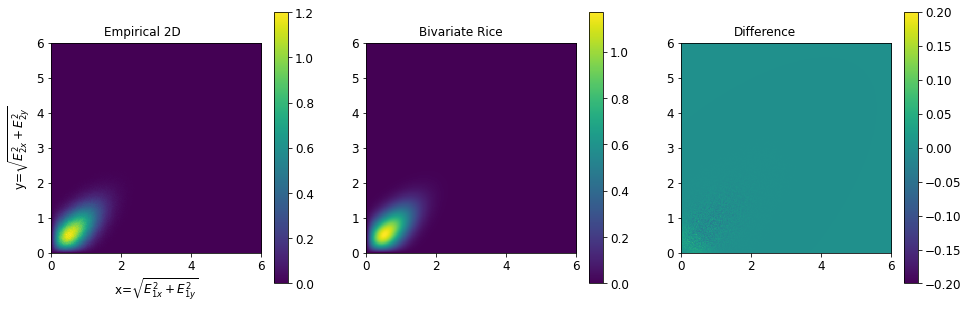

In [69]:
(xmax,ymax) = (xy_max,xy_max)
xedges = np.linspace(0,xmax,nx+1)
yedges = np.linspace(0,ymax,ny+1)
Hx_emp, xedges, yedges = np.histogram2d(R1_abs, R2_abs, bins=(xedges, yedges),density=True)

plt.figure(figsize=(16,5))                         
plt.subplot(1,3,1)        
plt.imshow(Hx_emp, interpolation='none', extent=[0,xmax,0,ymax],origin='lower')
plt.xlabel(r"x=$\sqrt{E_{1x}^2+E_{1y}^2}$"); plt.ylabel(r"y=$\sqrt{E_{2x}^2+E_{2y}^2}$")
plt.text(1.5,6.2,"Empirical 2D")
plt.colorbar(); 

plt.subplot(1,3,2)        
plt.imshow(result, interpolation='none', extent=[0,xmax,0,ymax],origin='lower')
plt.text(1.5,6.2,"Bivariate Rice")
plt.colorbar()
                         
plt.subplot(1,3,3)
plt.imshow(Hx_emp-result, interpolation='none', extent=[0,xmax,0,ymax],origin='lower',vmin=-0.2,vmax=0.2)
plt.text(1.5,6.2,"Difference")
plt.colorbar(); plt.show()

Up to numerical and sampling errors, the empirical 2D looks very similar to the bivariate Rice distribution. 

# Normal approximations to the distribution of $\Delta|E|$

It is also of interest to determine if we can approximate the distribution of differences in structure factor amplitudes directly. If so, we could approximate $P\left(|E_1|,|E_2|\right)\approx P\left(|E_2|-|E_1|\right)\cdot P\left(|E_1|\right)$. 

First, we will take a look at the normal approximation of the Rice distribution. 

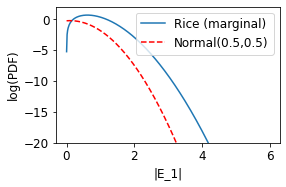

In [70]:
plt.figure(figsize=(4,2.5))

plt.plot(xbase,np.log((6/200)*np.sum(result,axis=0)),label="Rice (marginal)")
loc=np.sqrt(np.sum(mean[[0,2]]**2))

plt.plot(xbase,np.log(norm.pdf(xbase,loc=loc, scale=0.5)),'r--',label="Normal(0.5,0.5)")
plt.ylabel("log(PDF)")
plt.xlabel("|E_1|")
plt.ylim([-20,2])
plt.legend()
plt.show()

Pretty bad!

### Acentric $\Delta|E|$
In contrast, we find that the differences in structure factor amplitudes between related datasets can often be captured quite accurately using normal distributions.

[]

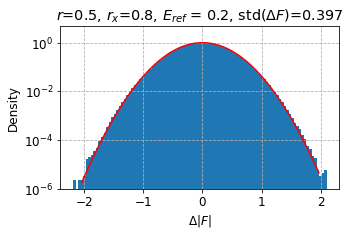

In [71]:
plt.figure(figsize=(5,3))
plt.hist(R1_abs-R2_abs,100, density=True)
plt.yscale("log")
xl=plt.xlim()
yl=plt.ylim()

x=np.linspace(0.85*xl[0],0.85*xl[1],100)
y1=   norm.pdf(x,0,np.std(R1_abs-R2_abs))
# y2=laplace.pdf(x,0,np.std(R1_abs-R2_abs)/np.sqrt(2))

plt.plot(x,y1,'r-')
# plt.plot(x,y2,'m-')
plt.ylim(yl)
ref="{ref}"
plt.title(f"$r$={r}, $r_x$={rx}, $E_{ref}$ = {Eref}, std($\Delta F$)={np.std(R1_abs-R2_abs):.3}")
plt.xlabel(r"$\Delta |F|$")
plt.ylabel("Density")
plt.ylim([1e-6,5])
plt.grid(linestyle="--")
plt.savefig(fig_dir+f"acentric_differences_r{r}_Eref{Eref}.svg")
plt.plot()

### Centric $\Delta|E|$

To compute $\Delta|E|$, we first compute the conditional distribution of $|E_{1c}|,|E_{2c}|$ given $|E_{3c}|$, analogous to the above two sections.

Following https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions, 

$$
P\left(E_{1c},E_{2c} | E_{3c}\right) = N\left(r E_{3c},C_{1c|3c}\right)
$$

with 

$$
C_{1c|3c} = 
\begin{bmatrix}
1   -r^2 & r_x -r^2 \\
r_x -r^2 & 1   -r^2         
\end{bmatrix}
$$

We then have that 

$$
P\Bigl(|E_{1c}|,|E_{2c}| \Big| |E_{3c}|\Bigr) = P\Bigl(E_{1c},E_{2c} \Big| E_{3c}\Bigr) + 
                                             P\Bigl(-E_{1c},E_{2c} \Big| E_{3c}\Bigr) +
                                             P\Bigl(E_{1c},-E_{2c} \Big| E_{3c}\Bigr) +
                                             P\Bigl(-E_{1c},-E_{2c} \Big| E_{3c}\Bigr)
$$

There should not be any need to further simplify this.

We implemented two ways to calculate the folded normal--in terms of $r$, $r_x$, $\Sigma$, $E_3$ or in terms of the conditional mean and variance

In [72]:
r   = 0.5 #0.95 #
rx  = 0.8
E3  = 0.2/r #2.0/r #
mean= r*np.asarray([E3,E3])
cov = np.asarray([[ 1-r**2, rx-r**2],\
                  [rx-r**2,  1-r**2]])

print(bivariate_tools.FoldedNorm2D_wrapper(3, 2, rx=rx, Sigma=1.0, E3=E3, r=r))
print(bivariate_tools.FoldedNorm2D(3,2, mean, cov))

0.0018564955499625726
0.0018564955499625726


In [73]:
rng = default_rng()
n_samples=int(1e7)

# print(cov)
vals = rng.multivariate_normal(mean,cov,n_samples)
R1_abs=np.abs(vals[:,0])
R2_abs=np.abs(vals[:,1])

In [74]:
nx, ny = (200,200)
xy_max = 4
xbase  = np.linspace(0.001, xy_max, nx)
ybase  = np.linspace(0.001, xy_max, ny)
xx,yy  = np.meshgrid(xbase,ybase)
y_in   = np.transpose(np.array([xx.flatten(), yy.flatten()]))
print(y_in.shape)

t1_start = perf_counter()  
result = bivariate_tools.FoldedNorm2D_all(y_in[:,0].reshape(-1,1), y_in[:,1].reshape(-1,1), mean, cov)
result = result.reshape(nx,ny)
print(result.shape)
t1_end = perf_counter()  

print(f"Elapsed time: {t1_end-t1_start:.3} s")
print(f"Integrated probability density: {np.sum(result[:])*((xy_max/nx)*(xy_max/ny)):.3}")

(40000, 2)
(200, 200)
Elapsed time: 0.0063 s
Integrated probability density: 1.01


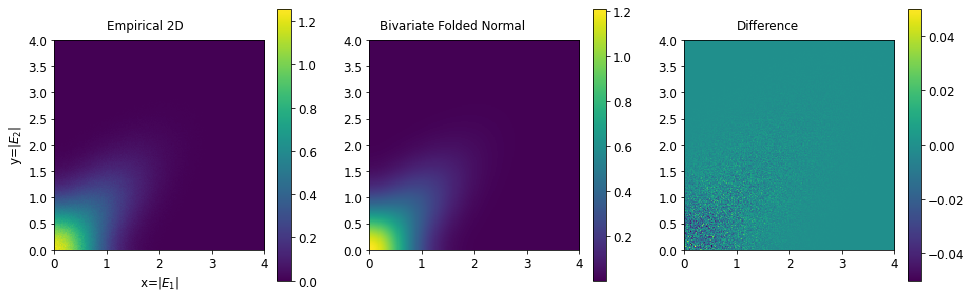

In [75]:
xedges = np.linspace(0,4,201)
yedges = np.linspace(0,4,201)
Hx_emp, xedges, yedges = np.histogram2d(R1_abs, R2_abs, bins=(xedges, yedges),density=True)

plt.figure(figsize=(16,5))                         
plt.subplot(1,3,1)        
plt.text(1,4.2,"Empirical 2D")
plt.imshow(Hx_emp, interpolation='none', extent=[0,4,0,4],origin='lower')
plt.xlabel(r"x=$|E_1|$"); plt.ylabel(r"y=$|E_2|$")
plt.colorbar(); 

plt.subplot(1,3,2)        
plt.imshow(result, interpolation='none', extent=[0,4,0,4],origin='lower')
plt.text(0.2,4.2,"Bivariate Folded Normal")
plt.colorbar()
                         
plt.subplot(1,3,3)
plt.imshow(Hx_emp-result, interpolation='none', extent=[0,4,0,4],origin='lower',vmin=-0.05,vmax=0.05)
plt.text(1,4.2,"Difference")
plt.colorbar(); plt.show()

[]

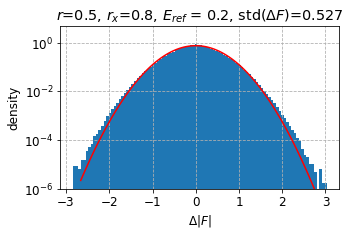

In [76]:
plt.figure(figsize=(5,3))
plt.hist(R1_abs-R2_abs,100, density=True)
plt.yscale("log")
xl=plt.xlim()
yl=plt.ylim()

x=np.linspace(0.85*xl[0],0.85*xl[1],100)
y1=   norm.pdf(x,0,np.std(R1_abs-R2_abs))
# y2=laplace.pdf(x,0,np.std(R1_abs-R2_abs)/np.sqrt(2))

plt.plot(x,y1,'r-')
# plt.plot(x,y2,'m-')
plt.ylim(yl)
ref="{ref}"
plt.title(f"$r$={r}, $r_x$={rx}, $E_{ref}$ = {mean[0]}, std($\Delta F$)={np.std(R1_abs-R2_abs):.3}")
plt.xlabel(r"$\Delta |F|$")
plt.ylabel("density")
plt.ylim([1e-6,5])
plt.grid(linestyle="--")
plt.savefig(fig_dir+f"centric_differences_r{r}_Eref{mean[0]}.svg")
plt.plot()

## Magnitude of $\sigma(\Delta|E|)$
We found that $\sigma(\Delta |E|)\approx\sqrt{1-r}$ for acentric reflections and $\sigma(\Delta |E|)\leq\sqrt{2(1-r)}$ for centric reflections. Small deviations occur when $E$ is close to zero (towards slightly smaller standard deviation). Histograms look perfectly gaussian in all cases considered.

See **effective_penalty_parameters_DeltaF.xlsx** in the `double-wilson` repository.

For a single acentric component, we can state that:
$$
\begin{align}
 Var(\Delta E_x)   & = Var\left(E_{1x} - (r E_{1x} + \sqrt{1-r^2} \eta_x)\right)  \\
                   & =  Var\left((1-r) E_{1x} - \sqrt{1-r^2} \eta_x\right)   \\
                   & =  \frac{1}{2}\left((1-r)^2 + (1-r^2) - 0\right)  \\
                   &  = (1-r) 
\end{align}
$$

where $r E_{1x}$ is the conditional mean of $E_{1x}$ and $\eta_x \sim \mathcal{N}(0,1/2)$ and Var($E_{1x}$) $=\frac{1}{2}$. We used that $(1-r)^2 + (1-r^2) = 2-2r$.

For a centric structure factor, we likewise obtain $Var(\Delta E)=2(1-r)$.

For centrics, that essentially settles why $Var(\Delta |E|) \leq 2(1-r)$, with the inequality coming from us not taking absolute values in the above equation. That is, $\left||E_1| - |E_2|\right| \leq \left|E_1 - E_2\right|$. As long as $r$ is fairly close to 1, $E_1$ and $E_2$ will be very likely to have the same phase, in which case equality holds.

For acentrics, the argument is more complicated. We can choose radial and transverse directions, apply the above argument to the radial dimension, and observe that the radial difference dominates the difference in absolute value, as long as $r$ is fairly close to 1.  